# Data Preprocessing

This notebook explains how to prepare the data cleaned in section 1.1 for use in the naive model set.


1. Problem Framing
2. Data Manipulation



## Problem Framing

Data read from the file load_forecast_2016_2018 is in the format:

|time |day_forecast|actual_load|
|-----|------------|---------------|
| 2016-01-01 00:00:00 | 23273.0 | 22431.0 |
| 2016-01-01 01:00:00	| 22495.0	| 21632.0 |
| 2016-01-01 02:00:00	| 21272.0	| 20357.0 |

In this form we will only be able to predict the next hour in advance. According to the problem definition the goal is to predict the next 24 hours in advance. The way to do this is to create a window of calendar days consisting of 24 hour segments. That way each indivdual hour from day-1, is used to predict each hour of the current day.

Isolating for only the actual_load, the data is reformatted into the following format


| date | h00 | h01 | ... | h23 |
|------|----|----|-----|-----|
| 2016-01-01 | 22431.0 | 21632.0 | ... | 24000.0 |
| 2016-01-01 | 22113.0 | 20515.0 | ... | 26029.0 |


Therefore the naive problem becomes predicting the next day's loads at any given hour using the previous day's hourly loads. We have reduced a multiple input, multiple output problem into 24 univariate naive predictions.





### Windowing and Walk Forward Validation

Using the above structure we can establish a window 



## Data Manipulation

In [25]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#read in the dataframe
data = pd.read_csv('./data/processed_data/load_forecast_2016_2018.csv', parse_dates=True, index_col='time')

#### Split apart dates and times

In [3]:
loads = data.loc['2016-01-01':'2016-01-05']

In [4]:
loads.loc[:,'year'] = loads.index.year
loads.loc[:,'month'] = loads.index.month
loads.loc[:,'day'] = loads.index.day
loads.loc[:,'hours'] = loads.index.hour

/Users/ns/anaconda3/envs/fuck/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ns/anaconda3/envs/fuck/lib/python3.6/site-packages/pandas/core/indexing.py:562: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/ns/anaconda3/envs/fuck/lib/python3.6/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [5]:
loads.head()

,day_forecast,actual_load,year,month,day,hours
time,,,,,,
2016-01-01 00:00:00,23273.0,22431.0,2016,1,1,0
2016-01-01 01:00:00,22495.0,21632.0,2016,1,1,1
2016-01-01 02:00:00,21272.0,20357.0,2016,1,1,2
2016-01-01 03:00:00,20022.0,19152.0,2016,1,1,3
2016-01-01 04:00:00,19148.0,18310.0,2016,1,1,4


In [6]:
loads.loc[:,'date'] = pd.to_datetime(loads.loc[:,['year', 'month', 'day']], format='%Y-%m-%d', errors='ignore')

In [7]:
loads.columns

Index(['day_forecast', 'actual_load', 'year', 'month', 'day', 'hours', 'date'], dtype='object')

In [9]:
loads = loads.set_index(pd.DatetimeIndex(loads['date']))


In [15]:
loads_cond = loads.loc[:,['actual_load', 'hours']]

In [16]:
loads_cond.head()

,actual_load,hours
date,,
2016-01-01,22431.0,0
2016-01-01,21632.0,1
2016-01-01,20357.0,2
2016-01-01,19152.0,3
2016-01-01,18310.0,4


In [18]:
loads_processed = loads_cond.pivot(columns='hours', values='actual_load')

In [19]:
loads_processed.head()

hours,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,22431.0,21632.0,20357.0,19152.0,18310.0,18054.0,18234.0,18596.0,18541.0,18942.0,...,23265.0,22061.0,21481.0,21830.0,24291.0,25234.0,25881.0,26149.0,25610.0,24000.0
2016-01-02,24937.0,23121.0,22101.0,21718.0,21760.0,22695.0,25689.0,30493.0,33164.0,34001.0,...,32099.0,31449.0,31179.0,31175.0,32515.0,34967.0,35381.0,34700.0,32055.0,28939.0
2016-01-03,27227.0,25292.0,24265.0,23774.0,23650.0,24275.0,27243.0,31518.0,34093.0,35371.0,...,33029.0,32344.0,31927.0,31824.0,32226.0,35161.0,36599.0,35729.0,33154.0,29838.0
2016-01-04,26751.0,24882.0,23736.0,23199.0,23000.0,23348.0,25748.0,29620.0,31776.0,33087.0,...,31594.0,30376.0,29915.0,29633.0,29158.0,29159.0,30469.0,32482.0,30508.0,28598.0
2016-01-05,23642.0,21990.0,20629.0,19865.0,19446.0,19248.0,19296.0,18956.0,20072.0,21911.0,...,23378.0,22190.0,21549.0,21233.0,21298.0,21756.0,22929.0,25815.0,25843.0,24167.0


In [32]:
h0_p = loads_processed.iloc[:,0]
loads_shifted = loads_processed.shift(1)
loads_shifted.head()

hours,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,22431.0,21632.0,20357.0,19152.0,18310.0,18054.0,18234.0,18596.0,18541.0,18942.0,...,23265.0,22061.0,21481.0,21830.0,24291.0,25234.0,25881.0,26149.0,25610.0,24000.0
2016-01-03,24937.0,23121.0,22101.0,21718.0,21760.0,22695.0,25689.0,30493.0,33164.0,34001.0,...,32099.0,31449.0,31179.0,31175.0,32515.0,34967.0,35381.0,34700.0,32055.0,28939.0
2016-01-04,27227.0,25292.0,24265.0,23774.0,23650.0,24275.0,27243.0,31518.0,34093.0,35371.0,...,33029.0,32344.0,31927.0,31824.0,32226.0,35161.0,36599.0,35729.0,33154.0,29838.0
2016-01-05,26751.0,24882.0,23736.0,23199.0,23000.0,23348.0,25748.0,29620.0,31776.0,33087.0,...,31594.0,30376.0,29915.0,29633.0,29158.0,29159.0,30469.0,32482.0,30508.0,28598.0


In [30]:
h0 = loads_shifted.iloc[:,0]
h0.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05'],
              dtype='datetime64[ns]', name='date', freq=None)

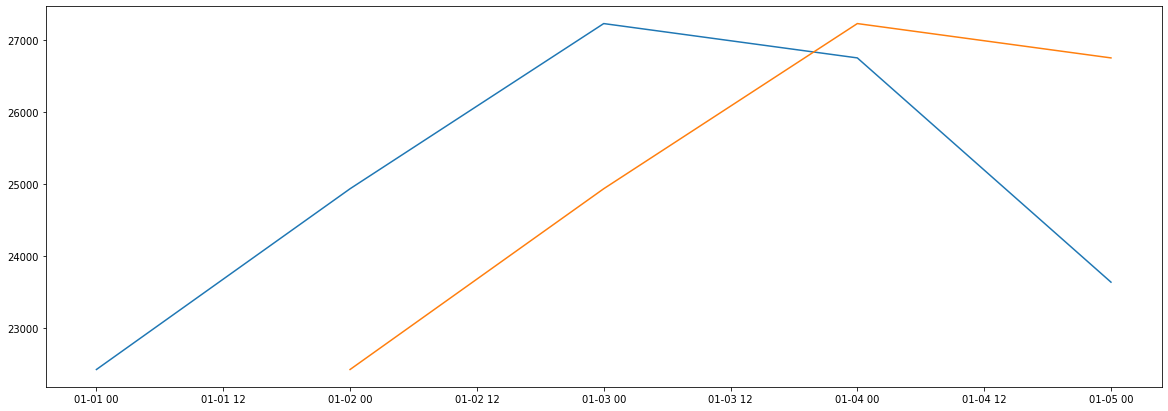

In [33]:
fig = plt.figure(figsize=(20,7))

plt.plot(h0_p.index, h0_p.values)
plt.plot(h0.index, h0.values)

Univariate defined:

- Input is 1 day of load measurements consisting of 24 hourly measurements.
- Output is 1 day of load predictions consistening of 24 hourly measurements.

Therefore in order to prepare the data for modelling it must be grouped by day, and converted to a numpy array.

### Desired Data Structure - Walk forward

The models use a walk forward structure where each t+1 is predicted on a daily time scale. Each day contains 24 hourly measurements. The resulting array size is:

(# days, 24)



In [42]:
#quick check. For 3 years of data including 1 leap year we expect 26304 measurements
len(data)

26304

In [76]:
data.head()

,day_forecast,actual_load
time,,
2016-01-01 00:00:00,23273.0,22431.0
2016-01-01 01:00:00,22495.0,21632.0
2016-01-01 02:00:00,21272.0,20357.0
2016-01-01 03:00:00,20022.0,19152.0
2016-01-01 04:00:00,19148.0,18310.0


In [ ]:
def shift_by_days(series, num_days):
    """
    Input a timeseries of the form 24 hourly measurements per day
    
    Output returns 
    
    """


In [46]:
data['actual_load'].values[:5]

array([22431., 21632., 20357., 19152., 18310.])

In [91]:
type(one_day_preprocess(data['actual_load'], 24)[0])

pandas.core.series.Series

In [124]:
test = one_day_preprocess(data['actual_load'].values, 24)

In [93]:
pd.DataFrame(test, columns=test.index)

TypeError: 'builtin_function_or_method' object is not iterable

In [88]:
test.index.day()

AttributeError: 'builtin_function_or_method' object has no attribute 'day'

In [123]:
def one_day_preprocess(series, sample_freq):
    """
    Input a series array of values. 
    
    """

    data = np.split(series, len(series)/sample_freq)
    
    return np.array(data)

In [79]:
#this is data ready to be put into a naive walk forward 
one_day_preprocess(data['actual_load'].values, 24)[:1]

[array([22431., 21632., 20357., 19152., 18310., 18054., 18234., 18596.,
        18541., 18942., 20484., 21805., 22607., 23178., 23265., 22061.,
        21481., 21830., 24291., 25234., 25881., 26149., 25610., 24000.])]

In [78]:
#we can confirm the data is alligned by looking at the first and last entries
data['actual_load'].head(24)

time
2016-01-01 00:00:00    22431.0
2016-01-01 01:00:00    21632.0
2016-01-01 02:00:00    20357.0
2016-01-01 03:00:00    19152.0
2016-01-01 04:00:00    18310.0
2016-01-01 05:00:00    18054.0
2016-01-01 06:00:00    18234.0
2016-01-01 07:00:00    18596.0
2016-01-01 08:00:00    18541.0
2016-01-01 09:00:00    18942.0
2016-01-01 10:00:00    20484.0
2016-01-01 11:00:00    21805.0
2016-01-01 12:00:00    22607.0
2016-01-01 13:00:00    23178.0
2016-01-01 14:00:00    23265.0
2016-01-01 15:00:00    22061.0
2016-01-01 16:00:00    21481.0
2016-01-01 17:00:00    21830.0
2016-01-01 18:00:00    24291.0
2016-01-01 19:00:00    25234.0
2016-01-01 20:00:00    25881.0
2016-01-01 21:00:00    26149.0
2016-01-01 22:00:00    25610.0
2016-01-01 23:00:00    24000.0
Name: actual_load, dtype: float64

In [81]:
#check the last values of the series
one_day_preprocess(data['actual_load'].values, 24)[-1]

array([24312., 22140., 20851., 20200., 20006., 20366., 21723., 23850.,
       25969., 28382., 29873., 29753., 28982., 28636., 27988., 27009.,
       26449., 26738., 29592., 30653., 29735., 28071., 25801., 24455.])

In [137]:
data['actual_load'].head(48)

time
2016-01-01 00:00:00    22431.0
2016-01-01 01:00:00    21632.0
2016-01-01 02:00:00    20357.0
2016-01-01 03:00:00    19152.0
2016-01-01 04:00:00    18310.0
2016-01-01 05:00:00    18054.0
2016-01-01 06:00:00    18234.0
2016-01-01 07:00:00    18596.0
2016-01-01 08:00:00    18541.0
2016-01-01 09:00:00    18942.0
2016-01-01 10:00:00    20484.0
2016-01-01 11:00:00    21805.0
2016-01-01 12:00:00    22607.0
2016-01-01 13:00:00    23178.0
2016-01-01 14:00:00    23265.0
2016-01-01 15:00:00    22061.0
2016-01-01 16:00:00    21481.0
2016-01-01 17:00:00    21830.0
2016-01-01 18:00:00    24291.0
2016-01-01 19:00:00    25234.0
2016-01-01 20:00:00    25881.0
2016-01-01 21:00:00    26149.0
2016-01-01 22:00:00    25610.0
2016-01-01 23:00:00    24000.0
2016-02-01 00:00:00    22113.0
2016-02-01 01:00:00    20515.0
2016-02-01 02:00:00    19284.0
2016-02-01 03:00:00    18637.0
2016-02-01 04:00:00    18352.0
2016-02-01 05:00:00    18574.0
2016-02-01 06:00:00    19751.0
2016-02-01 07:00:00    20857.0
201

In [135]:
data.stack()

time                             
2016-01-01 00:00:00  day_forecast    23273.0
                     actual_load     22431.0
2016-01-01 01:00:00  day_forecast    22495.0
                     actual_load     21632.0
2016-01-01 02:00:00  day_forecast    21272.0
                     actual_load     20357.0
2016-01-01 03:00:00  day_forecast    20022.0
                     actual_load     19152.0
2016-01-01 04:00:00  day_forecast    19148.0
                     actual_load     18310.0
2016-01-01 05:00:00  day_forecast    18750.0
                     actual_load     18054.0
2016-01-01 06:00:00  day_forecast    18729.0
                     actual_load     18234.0
2016-01-01 07:00:00  day_forecast    18647.0
                     actual_load     18596.0
2016-01-01 08:00:00  day_forecast    18242.0
                     actual_load     18541.0
2016-01-01 09:00:00  day_forecast    18164.0
                     actual_load     18942.0
2016-01-01 10:00:00  day_forecast    19478.0
                     

In [128]:
#creates a tensor from the data
dataset = tf.data.Dataset.from_tensor_slices(test)

In [115]:
dataset = dataset.window(size=1, shift = 1, drop_remainder = True)

In [116]:
dataset = dataset.flat_map(lambda window: window.batch(1))

In [108]:
dataset = dataset.batch(32)

In [109]:
dataset.as_numpy()

AttributeError: 'BatchDataset' object has no attribute 'as_numpy'

In [130]:
dataset = tf.data.Dataset.from_tensor_slices(data['actual_load'].values)
dataset = tf.data.Dataset.window(dataset, size=24, shift=1, drop_remainder=True, stride=24)
dataset = tf.

In [132]:
data.head()

,day_forecast,actual_load
time,,
2016-01-01 00:00:00,23273.0,22431.0
2016-01-01 01:00:00,22495.0,21632.0
2016-01-01 02:00:00,21272.0,20357.0
2016-01-01 03:00:00,20022.0,19152.0
2016-01-01 04:00:00,19148.0,18310.0


In [136]:
data.shift(1)

,day_forecast,actual_load
time,,
2016-01-01 00:00:00,NaN,NaN
2016-01-01 01:00:00,23273.0,22431.0
2016-01-01 02:00:00,22495.0,21632.0
2016-01-01 03:00:00,21272.0,20357.0
2016-01-01 04:00:00,20022.0,19152.0
2016-01-01 05:00:00,19148.0,18310.0
2016-01-01 06:00:00,18750.0,18054.0
2016-01-01 07:00:00,18729.0,18234.0
2016-01-01 08:00:00,18647.0,18596.0
